# [E-06] AI로 작사를 한다는 것


<br>

< 목 차 >

###I.   서 론

###II.  본 론

1. **문장 생성; validation loss 평가**  

    1) Baseline 구축  
    2) Hyper parameter 조정  
    3) Vocabulary 확대

2. **시적표현 선별; 정성적 평가**  
3. **Case study**  



###III. 결 론

<br><br><br>





---

# **I.  서 론**

<br>


####**[ 배경 및 의의 ]**

**작사**(作詞), 노랫말을 만드는 것. 

이번 과정에서는 Deep learning 중에서도 **순환신경망(RNN)**을 활용하여 작사를 하는 인공지능을 구현해 본다. 노랫말에는 감정과 생각이 넘치게 담겨있거나 극도로 절제되어 있다. 시적허용이 빈번한 언어표현 중 하나이기도 하다. 그저 '문장 생성'이 아니라 '작사'라면 단순히 어법에 맞는 문장을 만들어내는 그 이상이 되어야 할 것이다. 특히 노래가사가 갖는 함축적이고 은유적인 특성을 담아낼 수 있어야 한다. 그게 가능할까.

진심을 담은 글은 사람의 마음도 움직이게 할 수 있다고 믿으며 살았다. 기계가 만들어낸 문장이 사람의 마음을 움직일 수 있을지, 그리고 그런 작업을 내 손으로 해낼 수 있을지. 기대가 되면서도 또 한편으론 묘한 감정으로 Exploration을 시작한다.

<br>

####**[ 목표 ]**
*   자연어 전처리 과정의 이해
*   RNN(Recurrent Neural Network)을 활용한 MODEL 구현
*   뜻이 통하는 문장의 생성
*   노랫말로서의 평가 및 함의 도출
*   성능향상을 위한 방안 고찰


<br><br><br>




---

# **II. 본 론**

이번에 구현할 RNN(Recurrent Neural Network) MODEL에서 조정할 수 있는 주요 인자 가운데 Embedding size, Hidden size, Batch size가 있다. 각각의 개념과 함께 함의를 생각봄으로써 어떤 방식으로 이를 조정해나갈 것인지 방향을 설정할 수 있을 것이다. 



<br>


**[개념 정리]**


**⎮ Embedding size**

Embedding 이란 가중치 매개변수로부터 단어에 해당하는 행(벡터)를 추출하는 계층이다. 이 Embedding 계층에 단어의 임베딩(분산 표현)이 저장된다. 

Embedding size는 워드 벡터의 차원수, 즉 단어가 추상적으로 표현되는 크기다. 값이 커질수록 단어의 추상적인 특징을 더 잡아낼 수 있지만 그만큼 충분한 데이터가 주어지지 않으면 오히려 혼란을 야기한다.[1]

<br>

**⎮ Hidden size**

RNN 계층의 순환구조 내에는 '닫힌 경로' 또는 '순환하는 경로'가 존재한다. 여기서 데이터가 순환하면서 정보가 끊임없이 갱신되는 것이다. 이로 인해 과거의 정보를 기억하는 동시에 최신 데이터로 갱신할 수 있다.[3] 

LMS 본문에서는 Hidden state의 차원수에 해당하는 Hidden size를 '모델에 얼마나 많은 일꾼을 둘 것인가'로 이해할 수 있다고 설명한다. 그 일꾼들이 모두 같은 데이터를 보고 각자의 생각을 가지는데, 충분한 데이터가 주어지면 올바른 결정을 내리겠지만 그렇지 않으면 역효과다. 

<br>

**⎮ Batch size**

Batch는 하나로 묶은 데이터를 한꺼번에 입력하여 처리하는 방식을 의미한다. Batch를 적용하여 개개의 데이터를 다룰 때보다 큰 배열의 정보를 효율적으로 처리할 수 있고 부하를 줄일 수 있다. 또한 데이터 학습 시 Batch 단위로 대표성을 지닌 가중치를 업데이트 함으로써 Model의 범용성을 높일 수 있다.

이때 어느 정도의 데이터를 한 묶음으로 나타낼 것인지가 Batch size다. 일반적으로 Batch size가 너무 클 경우 한 번에 처리해야 할 데이터가 많아지므로 메모리 부족문제가 발생할 수 있고, 너무 작을 경우에는 가중치 업데이트의 표본으로 역할이 어려울 수 있다.  

<br><br><br>


##**1. 문장 생성**; validation loss 평가




<br><br>

###**1) Data 처리 및 Baseline 구축**

<br>



In [ ]:
''' 구글드라이브 마운트 '''
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import glob
import tensorflow

In [ ]:
txt_file_path = '/content/drive/MyDrive/data/LSMdata/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ["Let's stay together I, I'm I'm so in love with you", 'Whatever you want to do', 'Is all right with me']


<br><br>

**[ 데이터 정제 ]**

preprocess_sentence() 함수를 활용하여 데이터를 정제한다. 이때 지나치게 긴 문장은 과도한 Padding의 원인이 될 수 있어서 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하였다.

In [ ]:
import os, re 
import numpy as np
import tensorflow as tf

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))

<start> this is sample sentence . <end>


In [ ]:
# 정제된 문장 수집
corpus = []

for sentence in raw_corpus:
    # 삭제
    if len(sentence) == 0: continue
    if sentence[-1] == ":": continue
    
    # 정제
    preprocessed_sentence = preprocess_sentence(sentence)
    if len(preprocessed_sentence.split()) > 15: continue   # 토큰 생성 시 15개 이상 제외
    corpus.append(preprocessed_sentence)
        
corpus[:10]

['<start> whatever you want to do <end>',
 '<start> is all right with me <end>',
 '<start> cause you make me feel so brand new <end>',
 '<start> loving you forever <end>',
 '<start> is what i need <end>',
 '<start> let me , be the one you come running to <end>',
 '<start> i ll never be untrue oh baby <end>',
 '<start> let s , let s stay together gether <end>',
 '<start> lovin you whether , whether <end>',
 '<start> times are good or bad , happy or sad <end>']

In [ ]:
corpus[0]

'<start> whatever you want to do <end>'

<br><br>

**[ 토큰 생성 ]**


TensorFlow의 Tokenizer와 pad_sequences를 사용하였다. 

12000단어를 기억할 수 있는 tokenizer를 생성하고, corpus를 이용해 tokenizer 내부의 단어장을 완성한다.

In [ ]:
def tokenize(corpus):
    # tokenizer
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용, tokenizer 내부의 단어장을 완성
    tokenizer.fit_on_texts(corpus)
    # corpus를 Tensor로 변환
    tensor = tokenizer.texts_to_sequences(corpus)   
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[  2 570   7 ...   0   0   0]
 [  2  26  25 ...   0   0   0]
 [  2  66   7 ...   0   0   0]
 ...
 [  2  21  77 ...   0   0   0]
 [  2  41  26 ...   0   0   0]
 [  2  21  77 ...   0   0   0]] <keras_preprocessing.text.Tokenizer object at 0x7ff24e16e3d0>


In [ ]:
print(tensor)
print(tokenizer)
type(tokenizer)

[[  2 570   7 ...   0   0   0]
 [  2  26  25 ...   0   0   0]
 [  2  66   7 ...   0   0   0]
 ...
 [  2  21  77 ...   0   0   0]
 [  2  41  26 ...   0   0   0]
 [  2  21  77 ...   0   0   0]]


keras_preprocessing.text.Tokenizer

In [ ]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


In [ ]:
# source 문장 생성
src_input = tensor[:, :-1]  

# target 문장 생성
tgt_input = tensor[:, 1:]    

print(src_input[0])
print(tgt_input[0])

[  2 570   7  64  10  48   3   0   0   0   0   0   0   0]
[570   7  64  10  48   3   0   0   0   0   0   0   0   0]


In [ ]:
from sklearn.model_selection import train_test_split

enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, 
                                                          tgt_input,
                                                          test_size=0.2,
                                                          shuffle=True, 
                                                          random_state=42)

print(enc_train.shape)
print(dec_train.shape)
print(enc_val.shape)
print(dec_val.shape)

(124810, 14)
(124810, 14)
(31203, 14)
(31203, 14)


이제, 데이터셋 객체를 생성한다. tf.data.Dataset객체를 생성하는 방법을 사용하고, 이 경우 데이터 입력 파이프라인을 통한 속도 개선 및 각종 편의 기능을 제공이 가능하다고 한다.

data.Dataset.from_tensor_slices() 메소드를 이용해 tf.data.Dataset객체를 생성하였다.

In [ ]:
BUFFER_SIZE = len(enc_train)
VAL_BUFFER_SIZE = len(enc_val)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 + 0:<pad>를 포함
VOCAB_SIZE = tokenizer.num_words + 1   

dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.shuffle(VAL_BUFFER_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset
val_dataset

<BatchDataset element_spec=(TensorSpec(shape=(256, 14), dtype=tf.int32, name=None), TensorSpec(shape=(256, 14), dtype=tf.int32, name=None))>

<br><br>

**[ Model Baseline ]**

Model Baseline을 구축한다. tf.keras.Model을 Subclassing하는 방식으로 1개의 Embedding 레이어, 2개의 LSTM 레이어, 1개의 Dense 레이어로 구성한다.

앞서 설명한 MODEL 주요인자(Embedding size, Hidden size)의 초기값은 LSM 본문에서 제시한 수치를 적용하였다.

In [ ]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out
    
embedding_size = 256
hidden_size = 1024
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [ ]:
# 데이터셋에서 데이터 한 배치만 불러와서 모델에 넣기 
for src_sample, tgt_sample in dataset.take(1): break

model(src_sample)

<tf.Tensor: shape=(256, 14, 12001), dtype=float32, numpy=
array([[[-2.99471649e-05, -1.44973428e-05,  3.18330385e-05, ...,
          3.14648350e-04,  2.06530021e-04,  8.14726664e-05],
        [-1.14914175e-04,  1.22720903e-05, -1.35023529e-05, ...,
          1.31604756e-04,  1.34788919e-04,  2.11093196e-04],
        [-2.55467487e-04,  4.14302689e-04, -3.21768021e-04, ...,
          5.45756775e-05,  9.59930694e-05,  2.55789229e-04],
        ...,
        [ 4.15577961e-04, -1.41334464e-03, -1.75792069e-04, ...,
         -1.73327129e-03, -1.50814676e-03, -1.33213529e-03],
        [ 4.65762976e-04, -1.45521958e-03, -2.33292812e-04, ...,
         -2.11211061e-03, -1.78880326e-03, -1.56622974e-03],
        [ 5.33356040e-04, -1.42603402e-03, -3.00203945e-04, ...,
         -2.42884853e-03, -2.05076626e-03, -1.75904576e-03]],

       [[-2.99471649e-05, -1.44973428e-05,  3.18330385e-05, ...,
          3.14648350e-04,  2.06530021e-04,  8.14726664e-05],
        [-3.54821350e-05,  4.58741561e-05,  6

<br><br>

Embedding 레이어, 2개의 LSTM 레이어, Dense 레이어로 구성된 Model 형태를 확인할 수 있다.

In [ ]:
model.summary()

Model: "text_generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  3072256   
                                                                 
 lstm (LSTM)                 multiple                  5246976   
                                                                 
 lstm_1 (LSTM)               multiple                  8392704   
                                                                 
 dense (Dense)               multiple                  12301025  
                                                                 
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


<br><br>

**[ Model fitting ]**

<br>

Model fitting 시, epoch가 일정 수준 이상이 되었을 때 과적합이 발생하는 것을 방지하고자 Callback을 적용하였다.

<br>

**⎮ CALLBACK**

Callback은 훈련과정 중간에 어떤 작업을 수행할 수 있게 하는 객체로, Keras에서 제공하는 클래스다. fit() method의 callbacks매개변수에 리스트로 전달하여 사용한다.[2]

**ModelCheckpoint**로 가장 낮은 손실값의 모델을 자동으로 저장해주고, **EarlyStopping**으로 손실값이 낮아지지 않으면 학습을 중지하도록 설정(patience=1)했다. ModelCheckpoint와 EarlySttopping을 함께 사용하면 과적합이 되지 않도록 조정하여 최상의 모델을 찾는 데 용이하며, 컴퓨터 자원 및 시간을 아낄 수 있다.

안전장치를 걸어두었으니 epoch 값은 300으로 설정하고, 학습을 시작한다.

In [ ]:
from tensorflow import keras

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

EPOCH = 300

# ModelCheckpoint
filename = 'best_epoch{}_batch{}.h5'.format(EPOCH, BATCH_SIZE)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filename,
                                                   monitor='val_loss',
                                                   verbose=1,
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   mode='auto')

# EarlyStopping 
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=1,
                                                   restore_best_weights=True)    # loss 증가 시 종료


model.compile(loss=loss, optimizer=optimizer)
hist = model.fit(dataset,
          validation_data=val_dataset,
          epochs=EPOCH,
          callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/300
487/487 [==============================] - ETA: 0s - loss: 3.4957
Epoch 1: val_loss improved from inf to 3.12609, saving model to best_epoch300_batch256.h5
487/487 [==============================] - 52s 100ms/step - loss: 3.4957 - val_loss: 3.1261
Epoch 2/300
487/487 [==============================] - ETA: 0s - loss: 3.0198
Epoch 2: val_loss improved from 3.12609 to 2.95559, saving model to best_epoch300_batch256.h5
487/487 [==============================] - 48s 98ms/step - loss: 3.0198 - val_loss: 2.9556
Epoch 3/300
487/487 [==============================] - ETA: 0s - loss: 2.8598
Epoch 3: val_loss improved from 2.95559 to 2.84718, saving model to best_epoch300_batch256.h5
487/487 [==============================] - 48s 98ms/step - loss: 2.8598 - val_loss: 2.8472
Epoch 4/300
487/487 [==============================] - ETA: 0s - loss: 2.7383
Epoch 4: val_loss improved from 2.84718 to 2.76984, saving model to best_epoch300_batch256.h5
487/487 [==============================] -

<br>

Epoch 18에서 val_loss 값이 2.42으로 가장 낮았다가 다음 번에 증가함을 알 수 있다. 아직 목표 손실값(2.2 이하)에는 미치지 못한다.

그래프로 확인해보면 다음과 같다.

<br>

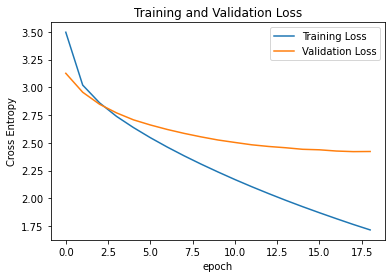

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(19)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')

plt.show()

<br><br>

**[문장 생성]**

generate_text 함수를 만들어, Model에게 시작 문장을 전달하면 Model이 이를 바탕으로 작문을 진행하게 한다.

In [ ]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=50):
    # init_sentence도 텐서로 변환
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

<br><br>

**[생성된 문장]**

Baseline Model을 통해 생성해 낸 문장은 다음과 같다. 아직 덜 완성된 듯한 문장도 보인다.

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s a monster <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> life")

'<start> life is a gamble better make a fuss <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> what a")

'<start> what a victorious thrill <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> we are in")

'<start> we are in a world , <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> mind is")

'<start> mind is when i see you <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> money is")

'<start> money is on my mind <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> first")

'<start> first i know i m a <unk> <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> The most important thing is")

'<start> the most important thing is <end> '

<br><br>

###**2) Hyper parameter 조정**

<br>

Baseline을 토대로 Hyper parameter를 조정하고, 이에 따른 Validation loss를 확인하였다. 수치를 변화시킴에 따라 훈련을 시키는 형태와 사이즈가 달라지며, 이로 인해 loss값이 달라짐을 알 수 있다. 

<br>

**[ Hyper parameter 조정 및 결과 ]**

| - | BATCH SIZE | EMBEDDING SIZE | HIDDEN SIZE | VALIDATION LOSS | BEST POINT | note |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|256|256| 1024 |**2.42**| epoch 18 | Baseline |
|2차|256|2048| 1024 |**2.29**| epoch 9 | - |
|3차|256|256| 2048 |**2.26**| epoch 15 | - |
|**4차**|**256**|**2048**| **2048** |**2.10**| **epoch 7** |  **✓ loss 2.2 이하 달성** |
|5차|128|256| 1024 |**2.44**| epoch 14 | Batch size 상관성 확인(1차 기준 Emb, Hidd 통제) |
|6차|512|256| 1024 |**2.41**| epoch 28 | Batch size 상관성 확인(1차 기준 Emb, Hidd 통제) |


<br>

validation loss를 기준으로, 4차 시도의 설정(batch size=256 , embedding size=2048 , hidden size=2048)을 적용했을 때 결과가 가장 양호했다. epoch 7 일 때 loss 2.10을 기록했다.

LMS에서 요구한 기본조건과 다른 설정(최대 토큰길이 등)으로 16회 가량 추가 테스트한 결과를 포함하여 고려하였을 때, EMBEDDING SIZE 및 HIDDEN SIZE가 증가함에 따라 대체적으로 loss가 낮아짐을 알 수 있었다.(음의 상관관계)

또한, BATCH SIZE도 loss값과 관련이 있는지 알아보기 위해 128, 256, 512로 값을 달리해가며 테스트하였으나 loss은 크게 달라지지 않았다. 


다음은 **loss 최소치(2.10)**를 보인 **4차 테스트**에 대한 내용이다.

In [ ]:
from tensorflow import keras

optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True,
    reduction='none'
)

EPOCH = 300

# ModelCheckpoint
filename = 'best_epoch{}_batch{}.h5'.format(EPOCH, BATCH_SIZE)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(filename,
                                                   monitor='val_loss',
                                                   verbose=1,
                                                   save_weights_only=True,
                                                   save_best_only=True,
                                                   mode='auto')

# EarlyStopping 
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=1,
                                                   restore_best_weights=True)    # 증가 1번까지만 참고 끝내는 걸로 변경


model.compile(loss=loss, optimizer=optimizer)
hist = model.fit(dataset,
          validation_data=val_dataset,
          epochs=EPOCH,
          callbacks=[checkpoint_cb, early_stopping_cb])

Epoch 1/300
487/487 [==============================] - ETA: 0s - loss: 3.1506
Epoch 1: val_loss improved from inf to 2.80135, saving model to best_epoch300_batch256.h5
487/487 [==============================] - 149s 298ms/step - loss: 3.1506 - val_loss: 2.8013
Epoch 2/300
487/487 [==============================] - ETA: 0s - loss: 2.6181
Epoch 2: val_loss improved from 2.80135 to 2.54780, saving model to best_epoch300_batch256.h5
487/487 [==============================] - 144s 295ms/step - loss: 2.6181 - val_loss: 2.5478
Epoch 3/300
487/487 [==============================] - ETA: 0s - loss: 2.2740
Epoch 3: val_loss improved from 2.54780 to 2.37036, saving model to best_epoch300_batch256.h5
487/487 [==============================] - 144s 295ms/step - loss: 2.2740 - val_loss: 2.3704
Epoch 4/300
487/487 [==============================] - ETA: 0s - loss: 1.9401
Epoch 4: val_loss improved from 2.37036 to 2.23908, saving model to best_epoch300_batch256.h5
487/487 [============================

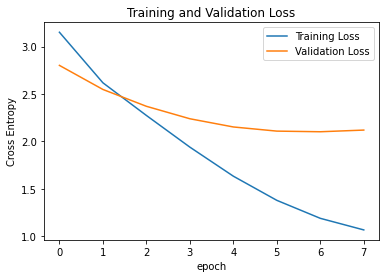

In [ ]:
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs_range = range(8)

import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.ylabel('Cross Entropy')

plt.show()

<br><br>

**[생성된 문장]**

Baseline Model을 통해 생성해 낸 문장에 비해 완성도가 있다. 또한 제법 긴 문장(first you get her name , then you get her number)도 만들어냈다.

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s the only one for me <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> life")

'<start> life s too short to not go for broke <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> what a")

'<start> what a girl is to do ? <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> we are in")

'<start> we are in the moment <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> mind is")

'<start> mind is like a compass <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> money is")

'<start> money is the motivation <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> first")

'<start> first you get her name , then you get her number <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> The most important thing is")

'<start> the most important thing is real <end> '

<br><br>

###**3) Vocabulary 확대**

<br>

앞서 토큰을 생성하는 과정에서 num_words = 12000을 설정했다. 12000 단어만 기억할 수 있는 tokenizer를 만들고, 여기 포함되지 않는 단어는 \<unk>으로 바꾸었다.

인수를 바꿔가며 테스트를 하는 과정에서 \<unk>이 쓰인 불완전한 문장도 여러번 발견되었다. 

*   money is a \<unk>
*   mind is a \<unk>
*   first i know i m a \<unk>

<br>

이런 문제를 해결하고, 보다 풍성한 표현의 작사를 할 수 있기를 기대하며 tokenizer의 num_words 설정을 달리해보았다. 

**단어수를 각각 16000개, 20000개로 증가**시켰다. 정확한 비교를 위해 다른 인수들은 loss 최저값을 기록한 4회차와 동일하게 설정한다.

<br>

다음은 Vocabulary 조정의 결과이다.

2회의 시도 모두 validation loss가 2.2 이하로 낮은 수치를 기록했다. 기본적으로 안정적인 문장을 생성했음을 알 수 있다.

<br>

**[ Vocabulary 조정 및 결과 ]**

| - | VOCABULARY | BATCH SIZE | EMBEDDING SIZE | HIDDEN SIZE | VALIDATION LOSS | BEST POINT | note |
|:---:|:---:|:---:|:---:|:---:|:---:|:---:|:---:|
|7차| **16000 words** |256|2048| 2048 |**2.15**| epoch 7 | |
|8차| **20000 words** |256|2048| 2048 |**2.17**| epoch 7 |  |

<br><br>

**⎮ 16000 words**

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s a monster <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> life")

'<start> life s trades . <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> what a")

'<start> what a lovely walk we ve taken ! <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> we are in")

'<start> we are in the same key <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> mind is")

'<start> mind is waiting <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> money is")

'<start> money is the motivation <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> first")

'<start> first i mma scorch her , then i mma torch her <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> The most important thing is")

'<start> the most important thing is the year <end> '

<br><br>

**⎮ 20000 words**

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s a highway chile <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> life")

'<start> life is a marathon <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> what a")

'<start> what a lovely walk we ve taken ! <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> we are in")

'<start> we are in the lab , we re not in the zone <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> mind is")

'<start> mind is a dialogue between <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> money is")

'<start> money is the motivation <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> first")

'<start> first you re up , then you re down and in between <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> The most important thing is")

'<start> the most important thing is making music and it s all <end> '

<br><br><br><br>

###**4) 소 결** 

<br><br>

**[ 문장 생성에서의 손실값(loss)에 대한 고찰 ]**

새롭게 만들어 낸 문장의 손실값(loss)을 구한다는 게 무슨 의미일까. 처음에는 수행목적과 전혀 일치하지 않는 평가방식이라고 생각했다. 전에 없던 문장을 창조해 냈는데 무엇과 비교를 해서 손실값을 구한다는 건가. 그게 무슨 의미가 있지? 

그러나 model의 구현방식을 자세히 들여다보고 나서야 이번 Exploration에서의 loss가 뜻하는 바를 이해하게 되었다.

<br>

src_input = tensor[:, :-1]  
tgt_input = tensor[:, 1:]

source문장과 target문장을 생성하는 위의 과정을 통해서 같은 문장 내의 뒷 단어를 label로 갖게 된다. 문장의 제일 마지막 단어는 label이 없다. 결국 정답이 있는 문제에 대해 최대의 확률값을 구하는 방식으로 다음에 올 단어를 유추하는 process가 구현된다.

우리가 generate_text Function을 통해 새로운 단어 또는 구(句)를 입력하여 문장을 생성해내는 과정 역시 이러한 방식에 기반하여 이루어진다. Entropy를 최소화하기 위한 다음 단어를 선택하게 되고, 선택을 올바르게 할수록 그 이후의 선택의 폭은 줄어든다. 

그렇다면 이번 Exploration에서 loss를 줄여나간다는 것은 문맥이나 용법 상 적정한 답을 찾아나간다는 의미도 있겠지만, 결국 제일 평범한 답을 찾는다는 의미가 될 수도 있겠다. 그런 관점에서 **loss를 목표로 삼는 것은 '작사'라는 영역을 평가하기에 온전한 지표는 아닐 수도 있겠다**는 생각이 들었다.

<br><br>

<br><br><br><br>



---




##**2. 시적표현 선별; 정성적 평가**

<br><br>

###**1) 회차별 문장력 비교**

<br>


그렇다면 다양한 인자 조정에 따른 loss값의 비교는 잠시 내려놓고, 각각의 문장력이 어떤지 살펴보자. 회차별로 모델이 생성해 낸 문장을 입력한 첫 단어(init_sentence)끼리 묶어서 살펴보고, 퀄리티를 비교했다.

문장력은 정성적으로 평가한다.(=내 마음이 움직이는 걸 뽑았다.)

<br>

**⎮ \<start> he** ㅡ 

<br>

| - ||LOSS| --------------------------------------------- SENTENCE --------------------------------------------- | QUALITY | note |
|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|| 2.42 |he **s a monster**| ★☆☆☆☆ | Baseline |
|2차|| 2.29 |he **s a monster**|★☆☆☆☆| - |
|3차|| 2.26 |he **s a monster**|★☆☆☆☆| - |
|4차|| 2.10 |he **s the only one for me** |★☆☆☆☆| - |
|5차|| 2.44 |he **s a monster**|★☆☆☆☆| - |
|6차|| 2.41 |he **s a monster**|★☆☆☆☆| - |
|7차|| 2.15 |he **s a monster**|★☆☆☆☆| 16000 words |
|8차|| 2.17 |he **s a highway chile**|★★★☆☆| 20000 words |

<br>

**⎮ \<start> life** ㅡ 

<br>

| - ||LOSS| --------------------------------------------- SENTENCE --------------------------------------------- | QUALITY | note |
|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|| 2.42 |life **is a gamble better make a fuss**| ★★☆☆☆ | Baseline |
|2차|| 2.29 |life **is worth living , so don t be alarmed**|★★★☆☆| - |
|3차|| 2.26 |life **is worth living again relationship on a ski slope**|★★★☆☆| - |
|4차|| 2.10 |life **s too short to not go for broke**|★★★★☆| - |
|5차|| 2.44 |life **is a marathon**|★☆☆☆☆| - |
|6차|| 2.41 |life **is a gamble , a long time ago**|★★☆☆☆| - |
|7차|| 2.15 |life **s trades**|★☆☆☆☆| 16000 words |
|8차|| 2.17 |life **is a marathon**|★☆☆☆☆| 20000 words |

<br>

**⎮ \<start> what a** ㅡ 

<br>

| - ||LOSS| --------------------------------------------- SENTENCE --------------------------------------------- | QUALITY | note |
|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|| 2.42 |what a **victorious thrill**| ★☆☆☆☆ | Baseline |
|2차|| 2.29 |what a **little bitty ?**|★☆☆☆☆| - |
|3차|| 2.26 |what a **girl is to do ?**|★☆☆☆☆| - |
|4차|| 2.10 |what a **girl is to do ?**|★☆☆☆☆| - |
|5차|| 2.44 |what a **victorious thrill**|★★☆☆☆| - |
|6차|| 2.41 |what a **lovely phrase i am a god**|★★☆☆☆| - |
|7차|| 2.15 |what a **lovely walk we ve taken !**|★☆☆☆☆| 16000 words |
|8차|| 2.17 |what a **lovely walk we ve taken !**|★☆☆☆☆| 20000 words |

<br>

**⎮ \<start> we are in** ㅡ 

<br>

| - ||LOSS| --------------------------------------------- SENTENCE --------------------------------------------- | QUALITY | note |
|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|| 2.42 |we are in **a world**| ★☆☆☆☆ | Baseline |
|2차|| 2.29 |we are in **the dark**|★★☆☆☆| - |
|3차|| 2.26 |we are in **the zone , damn near got my eyes closed**|★★★☆☆| - |
|4차|| 2.10 |we are in **the moment**|★★☆☆☆| - |
|5차|| 2.44 |we are in **the dark**|★★☆☆☆| - |
|6차|| 2.41 |we are in **the right**|★★☆☆☆| - |
|7차|| 2.15 |we are in **the same key**| ★★☆☆☆ |16000 words|
|8차|| 2.17 |we are in **the lab , we re not in the zone**|★★★★☆| 20000 words |

<br>

**⎮ \<start> mind is** ㅡ 

<br>

| - ||LOSS| --------------------------------------------- SENTENCE --------------------------------------------- | QUALITY | note |
|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|| 2.42 | mind is **when i see you**| ★☆☆☆☆ | Baseline |
|2차|| 2.29 |mind is **like a compass**|★☆☆☆☆| - |
|3차|| 2.26 |mind is **like a compass**|★☆☆☆☆| - |
|4차|| 2.10 |mind is **like a compass**|★☆☆☆☆| - |
|5차|| 2.44 |mind is **all i need**|★☆☆☆☆| - |
|6차|| 2.41 |mind is **a holiday**|★★★☆☆| - |
|7차|| 2.15 |mind is **waiting**|★★★☆☆| 16000 words |
|8차|| 2.17 |mind is **a dialogue between**|★★★★☆| 20000 words |

<br>

**⎮ \<start> money is** ㅡ 

<br>

| - ||LOSS| --------------------------------------------- SENTENCE --------------------------------------------- | QUALITY | note |
|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|| 2.42 |money is **on my mind**| ★☆☆☆☆ | Baseline |
|2차|| 2.29 |money is **a shame i m a fool now you re mine**|★★★☆☆| - |
|3차|| 2.26 |money is **the motivation**|★☆☆☆☆| - |
|4차|| 2.10 |money is **the motivation**|★☆☆☆☆| - |
|5차|| 2.44 |money is **the motivation**|★☆☆☆☆| - |
|6차|| 2.41 |money is **the motivation**|★☆☆☆☆| - |
|7차|| 2.15 |money is **the motivation**|★☆☆☆☆| 16000 words |
|8차|| 2.17 |money is **the motivation**|★☆☆☆☆| 20000 words |

<br>

**⎮ \<start> first** ㅡ 

<br>

| - ||LOSS| --------------------------------------------- SENTENCE --------------------------------------------- | QUALITY | note |
|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|| 2.42 |first **i know i m a \<unk>**| ☆☆☆☆☆ | Baseline |
|2차|| 2.29 |first **you get her name , then you get her number**|★★☆☆☆| - |
|3차|| 2.26 |first **i spin around and vomit then i shit up on it**|★☆☆☆☆| - |
|4차|| 2.10 |first **you get her name , then you get her number**|★★☆☆☆| - |
|5차|| 2.44 |first **i mma scorch her , then i mma torch her**|★★★★☆| - |
|6차|| 2.41 |first **i mma scorch her , then i mma torch her**|★★★★☆| - |
|7차|| 2.15 |first **i know i m a motherfucking monster**|★★☆☆☆| 16000 words |
|8차|| 2.17 |first **you re up , then you re down and in between**|★★☆☆☆| 20000 words |

<br>

**⎮ \<start> The most important thing is** ㅡ 

<br>

| - ||LOSS| --------------------------------------------- SENTENCE --------------------------------------------- | QUALITY | note |
|:---:|:---:|:---:|:---:|:---:|:---:|
|1차|| 2.42 |The most important thing is **-**| ☆☆☆☆☆ | Baseline |
|2차|| 2.29 |the most important thing is **real**|★☆☆☆☆| - |
|3차|| 2.26 |the most important thing is **ever promised tomorrow**|★★★☆☆| - |
|4차|| 2.10 |the most important thing is **real**|★☆☆☆☆| - |
|5차|| 2.44 |the most important thing is **\<unk>**|☆☆☆☆☆| - |
|6차|| 2.41 |the most important thing is **the year**|★☆☆☆☆| - |
|7차|| 2.15 |the most important thing is **-**|☆☆☆☆☆| 16000 words |
|8차|| 2.17 |the most important thing is **making music and it s all**|★★★☆☆| 20000 words |

<br><br><br>

###**2) 소 결**

<br>

loss값이 상대적으로 높더라도 비유적인 측면이나 창의성에서 한 번 더 생각하게 만드는 문장들이 있었다. 반면 loss값이 낮아서 더 좋은 결과물이라고 판단할만 하지만 사실상 진부한 표현도 있었다.

전반적으로 더 많은 단어를 포함한 tokenizer를 적용했을 때의 표현이 더 새롭고 풍성하다고 느껴졌으나, 일반화할 정도의 차이는 아니라고 판단된다. 

7차 시도는 loss가 2.15로 우수한 성능을 보인 경우이나, 'the most important thing is'의 입력값을 그대로 출력해냈다. \<end>로 바로 끝내버리는 게 확률적으로 유리했을지 모르지만 가사를 만들어내는 역할로서는 의미가 없다.

오히려 살짝 비문처럼 느껴지기도 하지만 그런 측면에서 오히려 예술성이 느껴지는 문장들은 이번 과정에서 loss를 성능의 지표로 삼는 것이 완벽하지 않음을 시사한다.


<br>

사실 가장 오랜시간 결과창을 들여다 보게 만들었던 문장은 가중치 설정 등의 측면에서 유효하지 않다고 판단하여 결과에서는 제외했던 테스트 가운데 있었다.

<br>

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> he")

'<start> he s a walker in the rain <end> '

In [ ]:
generate_text(model, tokenizer, init_sentence="<start> life")

'<start> life is a roller coaster but still unfair <end> '

-

<br><br><br><br><br><br>




---




##**3. Case study**

<br><br>

###**1) KoGPT2**

<br>

작사 관련 Exploration을 하면서 AI기반의 문장 생성에 관심이 생겼다. SKT에서 우리말을 기반으로 만든 Generative Pre-trained Transformer(GPT)을 경험해보자. 

GPT-2는 머신러닝 알고리즘을 활용해 입력된 샘플 텍스트를 구문론적, 문법적, 정보 등의 일관성을 갖춘 텍스트로 생성하는 자연어 처리 모델이다. 한국어로 학습된 오픈소스 기반 GPT-2 모델인 KoGPT-2는 질문에 대한 응답 생성, 문장 완성, 챗봇 등 한국어 해석이 필요한 여러 애플리케이션의 머신러닝 성능을 향상할 수 있다고 한다.

챗봇 구축, 텍스트 감성 예측, 텍스트 분석 기반 응답 생성에 사용될 수 있으며, 관심 있는 개발자는 모델과 관련 소스를 다운로드해 프로젝트에 적용하거나 수정하면 된다[4]ㅡ고 나와있다.


<br>


In [ ]:
!pip install transformers

     |████████████████████████████████| 4.2 MB 5.6 MB/s 
     |████████████████████████████████| 596 kB 56.0 MB/s 
     |████████████████████████████████| 6.6 MB 39.5 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from transformers import PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast.from_pretrained("skt/kogpt2-base-v2",
bos_token='</s>', eos_token='</s>', unk_token='<unk>',
pad_token='<pad>', mask_token='<mask>')
tokenizer.tokenize("이건 저도 처음 시도해보네요. 그럼우리 모두다 화이팅 아이펠🤗")

Downloading:   0%|          | 0.00/2.69M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/0.98k [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'GPT2Tokenizer'. 
The class this function is called from is 'PreTrainedTokenizerFast'.


['▁이건',
 '▁저',
 '도',
 '▁처음',
 '▁시도',
 '해보',
 '네',
 '요.',
 '▁그럼',
 '우리',
 '▁모두',
 '다',
 '▁화',
 '이팅',
 '▁아이',
 '펠',
 '🤗']

In [ ]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
text = '인공지능'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                           max_length=50,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

인공지능(AI) 기반의 스마트시티를 구축하는 데 주력할 계획이다.
이를 위해 올해부터 2022년까지 총 1조원을 투입한다.
이번 사업은 △스마트도시 조성 및 운영체계 고도화 사업(총사업비 2


In [ ]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
text = '사랑한다는 말은'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                           max_length=50,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

사랑한다는 말은, 그 자체가 하나의 '상징'일 수 있다.
그것은 바로 이 상상의 세계를 구성하는 것이다.
이러한 상상 세계는 어떤 특정한 대상을 향해 열려 있는 것이 아니라, 다른 대상과 함께 존재하는 것이기 때문이다.
따라서 우리는 이러한 상상력을 통해 우리가 경험


In [ ]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
text = '떴다. 떴다. 비행기 날아라. 날아라.'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                           max_length=50,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

떴다. 떴다. 비행기 날아라. 날아라."
"그럼, 비행기를 타고 가자."
비행기가 뜨자 나는 다시 한 번 하늘을 향해 외쳤다.
하늘을 향한 나의 시선은 하늘 위로 치솟았다.
나는 그제야 비로소 내 앞에 섰다.
그리고


In [ ]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
text = '건강한 생활'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                           max_length=50,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

건강한 생활습관을 개선하는 것이 중요하다.
특히, 스트레스를 많이 받는 사람은 피해야 한다.
스트레스가 쌓이면 면역력이 떨어지기 때문에 평소보다 더 많은 양의 음식을 섭취하고, 충분한 수면을 취하는 것도 도움이 된다.
또한 규칙적인 운동을 통해 스트레스의


In [ ]:
import torch
from transformers import GPT2LMHeadModel

model = GPT2LMHeadModel.from_pretrained('skt/kogpt2-base-v2')
text = '근력 운동을 할 때'
input_ids = tokenizer.encode(text, return_tensors='pt')
gen_ids = model.generate(input_ids,
                           max_length=50,
                           repetition_penalty=2.0,
                           pad_token_id=tokenizer.pad_token_id,
                           eos_token_id=tokenizer.eos_token_id,
                           bos_token_id=tokenizer.bos_token_id,
                           use_cache=True)
generated = tokenizer.decode(gen_ids[0])
print(generated)

근력 운동을 할 때 가장 중요한 것은 바로 운동이다.
운동할 때는 반드시 스트레칭을 해야 한다.
스트레스는 체내 호르몬 분비를 촉진시켜 근육과 인대의 긴장을 풀어주고 혈액순환을 원활하게 해 준다.
또한 스트레스를 해소하고 면역력을


<br>

전체적으로 구어체의 문장 보다는 문어체의 문장에 잘 맞는 것 같다. 노래가사와 같은 문구를 넣으면 주로 다음 줄에 대화체 형식의 문장이 이어져서 맥락이 깨지는 느낌을 받았다.

내용이 연결되는 듯 하면서 아닌 것도 같고, 어디선가 단순히 긁어오는 듯한 느낌도 없지 않다. 
'건강한 생활'이라는 입력문과 '근련 운동을 할 때'라는 입력문을 넣었을 때 결과를 비교해 보면, 문장구조가 유사하면서도 겹치지 않아서 단순히 붙여넣는 건 아닌 것 같기도 하다. 
다만 "근력 운동을 할 때 가장 중요한 것은 바로 운동이다."와 같이 의미상으로 중첩되는 문장을 생성하는 문제를 보였다.

transformer 등에 관한 기본지식을 쌓은 이후에, GPT가 어떤 방식으로 구현되는지 자세히 알아보는 것도 도움이 되겠다. 


-

<br><br><br><br><br><br>




---

# **III. 결 론**

<br>

* 해당 알고리즘도 결국 Lable이 있는 Classification의 일종이다.
* 적정 embedding size, hidden size 등의 설정을 통해 validation loss를 조절할 수 있다.
* tokenizer가 보유한 vocabulary의 양에 따라 validation loss를 조절할 수 있다.
* 다만, validation loss가 낮다고해서 목적에 부합하는 문장생성을 보장하는 것은 아니다.
* 문제의 성격에 따른 loss의 의미 이해가 요구되며, 필요 시 해당 문제에 부합하는 평가지표의 보완으로 효과적인 목적달성이 가능할 것으로 판단된다. 


<br>


####**[ 맺음말 ]**


이번 과정을 통해 구현해 낸 Model은 학습한 내용을 짜깁기하여 최대한 그럴 듯하게 유사한 문장을 생성해내는 것이겠지만, 입력으로 넣은 새로운 단어에 맞추어 문장을 만들어 주는 과정에서 마치 상호작용을 하는 듯한 느낌을 받았다. 

또한 생성한 문장이 내포하는 의미가 특정 성향이나 가치관과 결부된 경우를 보며, 기계에 의한 확률적 선택일 뿐 임에도 충분히 논란이 될 수 있겠다는 생각도 들었다. 

언어를 다루는 측면 때문일까. 이전 Exploration 과정들과는 확연히 구분되는 경험이었다. 주어진 데이터를 기반으로 AI가 만들어 낸 문장이 내포한 의미와 그 글귀를 보고 느끼는 감정은 어디에서 비롯되었다고 볼 것인가ㅡ하는 부질없는 물음이 남았다.


<br>




            
<br><br><br>



---

<br>

< 참고문헌 >

- LMS, E-06, 작사가 인공지능 만들기 [1]
- ⌈혼자 공부하는 머신러닝 딥러닝⌋, 한빛미디어, 박해선 지음 [2]
- 밑바닥부터 시작하는 딥러닝2 [3]
- https://github.com/SKT-AI/KoGPT2 [4]
- https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback

<br><br>

---

